In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.prepared import prep
import os
import matplotlib.pyplot as plt
# import contextily as ctx
from shapely.ops import unary_union


In [ ]:
BASE_DIR = 'D:/Desktop/mobility-seoul/'  # Change this to your base directory!
OUTPUT_CSV = 'D:/Desktop/mobility-seoul/graph_components/graph_components_intersections/node_urban_features.csv'
nodes_df = pd.read_csv(os.path.join(BASE_DIR, 'graph_components/graph_components_intersections/nodes_detailed.csv'), header=0)

# loading building and node data
gdf_buildings = gpd.read_file(os.path.join(BASE_DIR, 'Data/GIS data/Building footprints/merge_valid.shp'), crs='EPSG:5174')
gdf_nodes = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df['node_x'], nodes_df['node_y']), crs='EPSG:5174')

c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


In [ ]:
# loading and filtering green areas
gdf_green = gpd.read_file(os.path.join(BASE_DIR, 'Data/GIS data/Green/green/green_clipped.shp'))
gdf_green.to_crs(gdf_buildings.crs, inplace=True)

green_types = ['allotments', 'cemetery', 'farmland', 'farmyard', 'forest', 'grass', 'heath', 'meadow',
               'nature_reserve', 'orchard', 'park', 'scrub', 'vineyard'] # only these types are considered green areas
gdf_green = gdf_green[gdf_green['fclass'].isin(green_types)]

gdf_green = gdf_green.explode(index_parts=False).reset_index(drop=True)

merged_geoms = unary_union(gdf_green.geometry)

if isinstance(merged_geoms, MultiPolygon):
    merged_geoms = list(merged_geoms.geoms)
else:
    merged_geoms = [merged_geoms]

gdf_green = gpd.GeoDataFrame(geometry=merged_geoms, crs=gdf_green.crs)


# clipping green areas that overlap with buildings
sindex = gdf_buildings.sindex

def clip_with_local_buildings(green_geom):
    possible_matches_index = list(sindex.intersection(green_geom.bounds))
    local_buildings = gdf_buildings.iloc[possible_matches_index]
    overlaps = local_buildings[local_buildings.intersects(green_geom)]

    if not overlaps.empty:
        buildings_union = unary_union(overlaps.geometry)
        return green_geom.difference(buildings_union)
    else:
        return green_geom

gdf_green['geometry'] = gdf_green.geometry.apply(clip_with_local_buildings)

# removing green areas that are now empty (fully covered by buildings)
gdf_green = gdf_green[~gdf_green.geometry.is_empty]

In [4]:
# ensuring required attributes exist and are float
gdf_buildings['footprint'] = gdf_buildings['footprint'].astype(float)
gdf_buildings['gfa'] = gdf_buildings['gfa'].astype(float)

In [5]:
buffer_radius = 150  # meters
buffer_area = np.pi * buffer_radius ** 2

In [6]:
print("CRS of buildings:", gdf_buildings.crs)
print("CRS of nodes:", gdf_nodes.crs)
print(gdf_buildings.is_valid.value_counts())

CRS of buildings: EPSG:5174
CRS of nodes: EPSG:5174
True    597234
Name: count, dtype: int64


In [8]:
# feature calculations

def calc_GSI(intersected, buffer_area):
    '''
    GSI (Ground Space Index) = Footprint / Area of the buffer 
    '''
    footprint_weighted = (intersected['footprint'] * (intersected['area_overlap'] / intersected.geometry.area)).sum()
    gsi = footprint_weighted / buffer_area if buffer_area > 0 else np.nan
    return np.clip(gsi, 0, 1) if not np.isnan(gsi) else np.nan
    # return footprint_weighted / buffer_area if buffer_area > 0 else np.nan



def calc_FSI(intersected, buffer_area):
    '''
    FSI (Floor Space Index) = GFA / Area of the buffer 
    '''
    gfa_weighted = (intersected['gfa'] * (intersected['area_overlap'] / intersected.geometry.area)).sum()
    return gfa_weighted / buffer_area if buffer_area > 0 else np.nan


def calc_OSR(FSI, GSI):
    '''
    OSR (Open Space Ratio) = (1 - GSI) / FSI
    '''
    return (1 - GSI) / FSI if FSI > 0 else np.nan


def calc_ABH(intersected):
    '''
    ABH (Average Building Height) = Average of building heights
    '''
    return intersected['height_1'].mean()


def calc_WMHB(intersected):
    '''
    WMHB (Area-Weighted Mean Building Height) = Sum of (height * footprint) / Sum of footprint
    '''
    heights = intersected['height_1']
    weights = intersected['area_overlap']
    return np.average(heights, weights=weights) if weights.sum() > 0 else np.nan


def calc_HSTD(intersected):
    '''
    HSTD (Standard Deviation of Building Height)
    '''
    return intersected['height_1'].std()

def calc_GrCR(green_overlap_area, area_buffer):
    '''
    GrCR (Green Coverage Ratio) = Green Area / Area of the buffer
    '''
    grcr = green_overlap_area / area_buffer if area_buffer > 0 else np.nan
    return np.clip(grcr, 0, 1) if not np.isnan(grcr) else np.nan
    #return green_overlap_area / area_buffer if area_buffer > 0 else np.nan


def calc_GD(point, green_gdf, green_sindex):
    '''
    GD (Green Distance): distance from the node to the nearest green polygon.
    If the point is inside a green polygon, distance is 0.
    '''
    if green_gdf.contains(point).any():
        return 0.0
    return green_gdf.distance(point).min()

In [9]:
eligible_types = {
    "intersection",
    "submunicipality_detailed",
}
gdf_nodes["eligible"] = gdf_nodes["node_type"].isin(eligible_types)

# initializing result columns 
feat_cols = ["FSI","GSI","OSR","ABH","WMHB","HSTD","GrCR","GD"]

for c in feat_cols:
    gdf_nodes[c] = np.where(gdf_nodes["eligible"], np.nan, -1.0)

Processing node 151...
151 - 1 of 8: 0.0006073315420284535, 0.0007689332818760372, 1645.2810327959387, 3.0, 3.0, nan, 0.9935851012166707, 0.0
Processing node 93...
93 - 2 of 8: 1.8971382028837116, 0.18168036010632174, 0.43134424189540116, 17.210526315789473, 19.576443638289472, 17.734007481027138, 0.10831640012144461, 96.38549386824171
Processing node 1...
1 - 3 of 8: 1.339634473337744, 0.3263961681608195, 0.5028265883311244, 9.047619047619047, 13.982636561016788, 7.4638940430390806, 0.1119416024760598, 13.130136439585442
Processing node 68...
68 - 4 of 8: 0.3865151934599335, 0.09391837889892177, 2.3442328695805936, 7.455696202531645, 13.132597445352056, 11.112244884273487, 0.4018185009590676, 31.455411803571486
Processing node 6...


C:\Users\Michele\AppData\Local\Temp\ipykernel_9000\951291081.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


6 - 5 of 8: 2.561411394431635, 0.47281550247281867, 0.20581797155788834, 6.181818181818182, 24.29146599240336, 7.019601216905629, 0.0, 308.6673195662085
Processing node 49...
49 - 6 of 8: 1.3967028960612862, 0.25152208929063785, 0.5358891377830433, 11.924242424242424, 16.31518494293632, 10.141458416372414, 0.05193601748997889, 60.441113067217245
Processing node 19...
19 - 7 of 8: 0.5269058078727167, 0.08405171847338726, 1.7383529804398665, 10.161290322580646, 19.963989805448207, 11.450812195958761, 0.07832233713902295, 62.57915622961679
Processing node 14...


C:\Users\Michele\AppData\Local\Temp\ipykernel_9000\951291081.py:70: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)


14 - 8 of 8: 1.031923053378576, 0.38386502800879707, 0.5970745299021485, 5.417543859649123, 6.450586592656755, 5.449290004373665, 0.0, 202.9758556694779


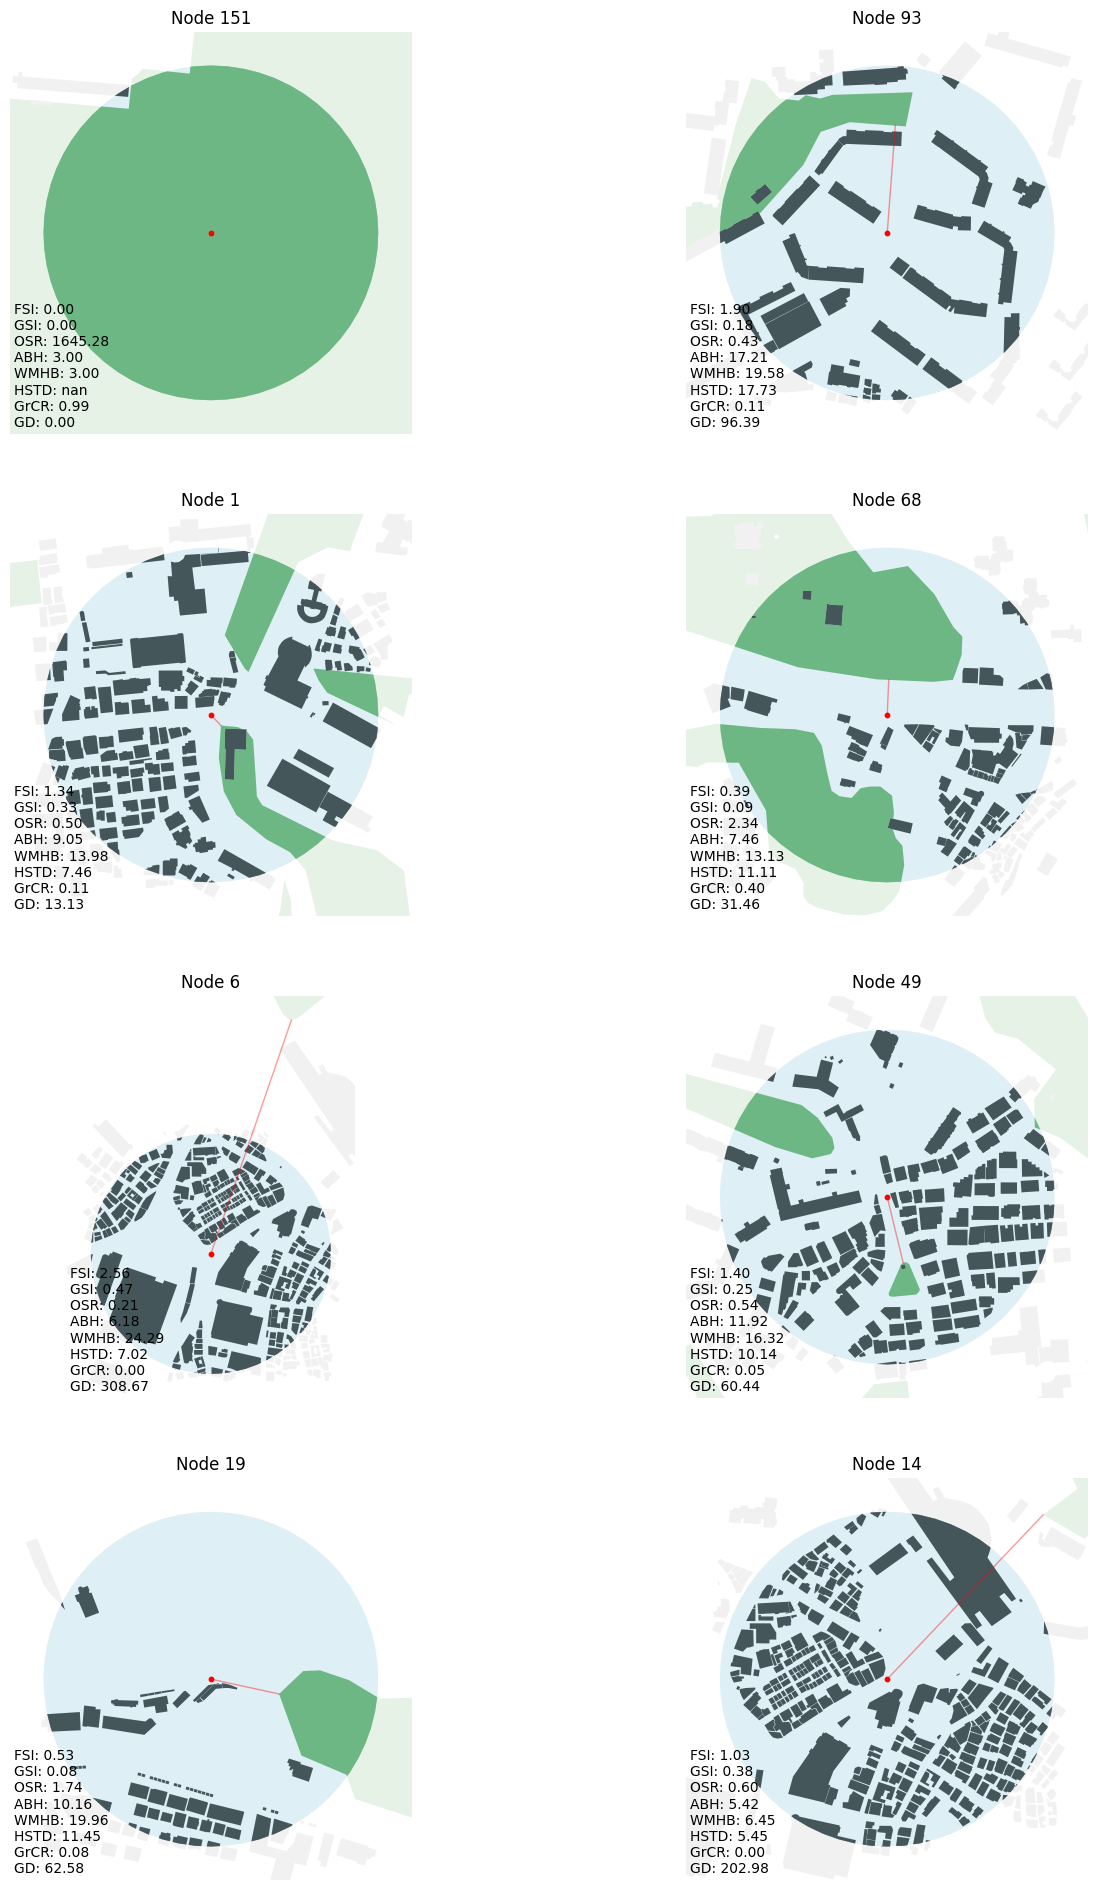

In [ ]:
from shapely.ops import nearest_points

# selecting 8 random nodes
sampled_nodes = gdf_nodes[gdf_nodes["eligible"]].sample(n=8, random_state=42)

# building spatial index
buildings_sindex = gdf_buildings.sindex
green_sindex = gdf_green.sindex

# creating plots
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten()

for idx, (node_idx, node) in enumerate(sampled_nodes.iterrows()):
        print(f'Processing node {node_idx}...')
        ax = axes[idx]
        buffer_geom = node.geometry.buffer(buffer_radius)

        possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
        buildings_candidates = gdf_buildings.iloc[possible_idx]
        buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()

        # if buildings_in_buffer.empty:
        #         continue

        buildings_in_buffer['area_overlap'] = buildings_in_buffer.intersection(buffer_geom).area
        
        #print(buildings_in_buffer[['area_overlap']].describe())

        # if buildings_in_buffer['area_overlap'].sum() == 0:
        #         continue

        possible_green_idx = list(green_sindex.intersection(buffer_geom.bounds))
        green_candidates = gdf_green.iloc[possible_green_idx]
        green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()

        green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()
        fsi = calc_FSI(buildings_in_buffer, buffer_area)
        gsi = calc_GSI(buildings_in_buffer, buffer_area)
        osr = calc_OSR(fsi, gsi)
        abh = calc_ABH(buildings_in_buffer)
        wmhb = calc_WMHB(buildings_in_buffer)
        hstd = calc_HSTD(buildings_in_buffer)
        grcr = calc_GrCR(green_overlap_area, buffer_area)
        gd = calc_GD(node.geometry, gdf_green, green_sindex)

        gdf_nodes.at[node_idx, 'FSI'] = fsi
        gdf_nodes.at[node_idx, 'GSI'] = gsi
        gdf_nodes.at[node_idx, 'OSR'] = osr
        gdf_nodes.at[node_idx, 'ABH'] = abh
        gdf_nodes.at[node_idx, 'WMHB'] = wmhb
        gdf_nodes.at[node_idx, 'HSTD'] = hstd
        gdf_nodes.at[node_idx, 'GrCR'] = grcr


        # plotting elements
        buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_geom], crs=gdf_nodes.crs)
        node_center = gpd.GeoDataFrame(geometry=[node.geometry], crs=gdf_nodes.crs)

        # background elemetns
        buildings_candidates.plot(ax=ax, color='lightgrey', alpha=0.3)
        #green_candidates.plot(ax=ax, color='green', alpha=0.1)
        gdf_green.plot(ax=ax, color='green', alpha=0.1)

        # buildings and green areas in buffer
        buildings_in_buffer_intersection = buildings_in_buffer.intersection(buffer_geom)
        buildings_in_buffer_intersection.plot(ax=ax, color='black')

        green_in_buffer_intersection = green_in_buffer.intersection(buffer_geom)
        green_in_buffer_intersection.plot(ax=ax, color='green', alpha=0.7)
        
        # buffer and node center
        buffer_gdf.plot(ax=ax, facecolor='lightblue', alpha=0.4)
        node_center.plot(ax=ax, color='red', markersize=10, alpha=1)

        # nearest green area line
        distances = gdf_green.distance(node.geometry)
        min_idx = distances.idxmin()
        nearest_geom = gdf_green.loc[min_idx].geometry

        from shapely.ops import nearest_points
        nearest_point_on_green = nearest_points(node.geometry, nearest_geom)[1]

        ax.plot(
            [node.geometry.x, nearest_point_on_green.x],
            [node.geometry.y, nearest_point_on_green.y],
            color='red', linewidth=1, alpha=0.4
        )

        # setting axis limits slightly outside buffer
        # get bounds of buffer
        xmin, ymin, xmax, ymax = buffer_geom.bounds

        # include green line endpoints
        x_vals = [node.geometry.x, nearest_point_on_green.x]
        y_vals = [node.geometry.y, nearest_point_on_green.y]

        xmin = min(xmin, min(x_vals))
        xmax = max(xmax, max(x_vals))
        ymin = min(ymin, min(y_vals))
        ymax = max(ymax, max(y_vals))

        # add some padding
        padding = buffer_radius * 0.2  # 20% extra
        ax.set_xlim(xmin - padding, xmax + padding)
        ax.set_ylim(ymin - padding, ymax + padding)

        ax.set_title(f'Node {node_idx}')
        ax.set_axis_off()
        ax.text(0.01, 0.01,
            f'FSI: {fsi:.2f}\nGSI: {gsi:.2f}\nOSR: {osr:.2f}\nABH: {abh:.2f}\nWMHB: {wmhb:.2f}\nHSTD: {hstd:.2f}\nGrCR: {grcr:.2f}\nGD: {gd:.2f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom')
    
        print(f'{node_idx} - {idx+1} of 8: {fsi}, {gsi}, {osr}, {abh}, {wmhb}, {hstd}, {grcr}, {gd}')

In [11]:
# iterating through each node and calculating the urban features

buildings_sindex = gdf_buildings.sindex
green_sindex = gdf_green.sindex

for node_idx, node in gdf_nodes[gdf_nodes["eligible"]].iterrows():
    buffer_geom = node.geometry.buffer(buffer_radius)

    # buildings
    possible_idx = list(buildings_sindex.intersection(buffer_geom.bounds))
    buildings_candidates = gdf_buildings.iloc[possible_idx]
    buildings_in_buffer = buildings_candidates[buildings_candidates.intersects(buffer_geom)].copy()
    buildings_in_buffer["area_overlap"] = buildings_in_buffer.intersection(buffer_geom).area

    # green
    possible_green_idx = list(green_sindex.intersection(buffer_geom.bounds))
    green_candidates = gdf_green.iloc[possible_green_idx]
    green_in_buffer = green_candidates[green_candidates.intersects(buffer_geom)].copy()
    green_overlap_area = green_in_buffer.intersection(buffer_geom).area.sum()

    # metrics
    fsi = calc_FSI(buildings_in_buffer, buffer_area)
    gsi = calc_GSI(buildings_in_buffer, buffer_area)
    osr = calc_OSR(fsi, gsi)
    abh = calc_ABH(buildings_in_buffer)
    wmhb = calc_WMHB(buildings_in_buffer)
    hstd = calc_HSTD(buildings_in_buffer)
    grcr = calc_GrCR(green_overlap_area, buffer_area)
    gd = calc_GD(node.geometry, gdf_green, green_sindex)

    # write back using node_idx
    gdf_nodes.at[node_idx, 'FSI'] = fsi
    gdf_nodes.at[node_idx, 'GSI'] = gsi
    gdf_nodes.at[node_idx, 'OSR'] = osr
    gdf_nodes.at[node_idx, 'ABH'] = abh
    gdf_nodes.at[node_idx, 'WMHB'] = wmhb
    gdf_nodes.at[node_idx, 'HSTD'] = hstd
    gdf_nodes.at[node_idx, 'GrCR'] = grcr
    gdf_nodes.at[node_idx, 'GD'] = gd

    print(f'{node_idx} | FSI: {fsi:.2f}, GSI: {gsi:.2f}, OSR: {osr:.2f}, ABH: {abh:.2f}, WMHB: {wmhb:.2f}, HSTD: {hstd:.2f}, GrCR: {grcr:.2f}, GD: {gd:.2f}')


1 | FSI: 1.34, GSI: 0.33, OSR: 0.50, ABH: 9.05, WMHB: 13.98, HSTD: 7.46, GrCR: 0.11, GD: 13.13
2 | FSI: 1.01, GSI: 0.26, OSR: 0.73, ABH: 6.73, WMHB: 10.70, HSTD: 5.68, GrCR: 0.09, GD: 62.56
3 | FSI: 0.72, GSI: 0.20, OSR: 1.10, ABH: 7.12, WMHB: 10.90, HSTD: 5.25, GrCR: 0.30, GD: 13.71
4 | FSI: 1.56, GSI: 0.32, OSR: 0.44, ABH: 8.41, WMHB: 15.64, HSTD: 9.18, GrCR: 0.03, GD: 22.32
5 | FSI: 1.39, GSI: 0.29, OSR: 0.51, ABH: 10.53, WMHB: 15.48, HSTD: 9.02, GrCR: 0.01, GD: 139.62
6 | FSI: 2.56, GSI: 0.47, OSR: 0.21, ABH: 6.18, WMHB: 24.29, HSTD: 7.02, GrCR: 0.00, GD: 308.67
7 | FSI: 1.69, GSI: 0.26, OSR: 0.44, ABH: 12.35, WMHB: 19.57, HSTD: 8.91, GrCR: 0.00, GD: 162.49
8 | FSI: 1.27, GSI: 0.35, OSR: 0.51, ABH: 10.70, WMHB: 10.14, HSTD: 7.42, GrCR: 0.00, GD: 196.05
9 | FSI: 1.25, GSI: 0.26, OSR: 0.59, ABH: 12.42, WMHB: 15.52, HSTD: 8.21, GrCR: 0.00, GD: 145.95
10 | FSI: 1.77, GSI: 0.40, OSR: 0.34, ABH: 7.35, WMHB: 15.89, HSTD: 7.93, GrCR: 0.00, GD: 243.00
12 | FSI: 0.78, GSI: 0.16, OSR: 1.07, A

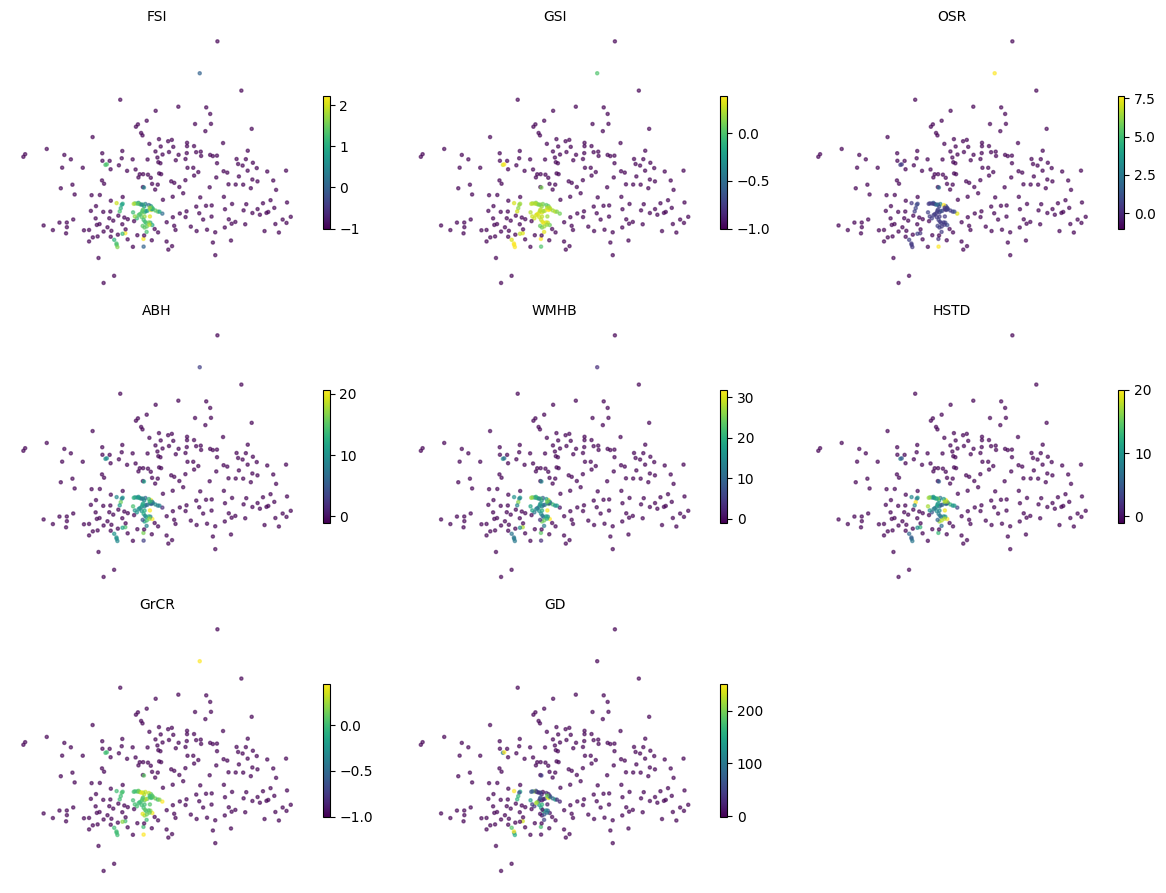

In [12]:
parameters = ['FSI', 'GSI', 'OSR', 'ABH', 'WMHB', 'HSTD', 'GrCR', 'GD']

n_params = len(parameters)
n_cols = 3
n_rows = (n_params + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for i, param in enumerate(parameters):
    ax = axes[i]
    data = gdf_nodes[param]

    # clipping color range to 1st–99th percentile to reduce outlier impact
    vmin = data.quantile(0.01)
    vmax = data.quantile(0.99)

    gdf_nodes.plot(
        ax=ax,
        column=param,
        cmap='viridis',
        legend=True,
        markersize=5,
        alpha=0.6,
        vmin=vmin,
        vmax=vmax,
        legend_kwds={'shrink': 0.5, 'label': ''}
    )

    ax.set_title(f'{param}', fontsize=10)
    ax.set_axis_off()

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [13]:
print(gdf_nodes.groupby("node_type")[feat_cols].mean(numeric_only=True))
print((gdf_nodes.loc[~gdf_nodes["eligible"], feat_cols] == -1).all().all())  # should be True

                                   FSI       GSI          OSR        ABH  \
node_type                                                                  
intersection                  1.347532  0.276909    72.107132  10.784111   
intersection_municipality     0.000607  0.000769  1645.281033   3.000000   
intersection_submunicipality -1.000000 -1.000000    -1.000000  -1.000000   
municipality                 -1.000000 -1.000000    -1.000000  -1.000000   
submunicipality              -1.000000 -1.000000    -1.000000  -1.000000   
submunicipality_detailed      1.199686  0.217061     1.123078  11.377365   

                                   WMHB       HSTD      GrCR          GD  
node_type                                                                 
intersection                  15.460039   9.423967  0.059050  138.863910  
intersection_municipality      3.000000        NaN  0.993585   -1.000000  
intersection_submunicipality  -1.000000  -1.000000 -1.000000   -1.000000  
municipality    

In [ ]:
output = gdf_nodes.drop(columns='geometry').copy()
output.to_csv(OUTPUT_CSV, index=False)
print(f"urban metrics saved to: {OUTPUT_CSV}")

urban metrics saved to: D:/Desktop/MSc Thesis - Copy/shapefiles/_network_parts_4_intersections/node_urban_features.csv
